#**DEEP LEARNING EXAM**
Riccardo Marvasi 0001103783

<br>
<br>

###**Motion Deblurring**

The project involves deblurring images. The blurred version is obtained through a superposition of slightly translated versions of the same image, following a random trajectory. This kind of blur is supposed to simulate the result of a shot taken with a shaky hand.

In [1]:
# Generals
import numpy as np
import matplotlib.pyplot as plt

# External libraries
from tqdm import tqdm
import tensorflow as tf
from keras import layers, models, backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras.models import Model

# Install/update the accelerate library
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.7 MB/s eta 0:00:00


<br>
<br>

# **Part 1 - Downloading data**

We work with images obtained from MNIST.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# Size check
print(f'Training set shape: {x_train.shape}\nTest set shape: {x_test.shape}')

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


Below you can find the generator you need to use for your project. Do not modify the number of moves, nor the range of translations. You are free to change the batchsize.

In [4]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

my_gen = generator(x_train,5)

In [5]:
# Functions to visualize images
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def plot_pair(x, y):
    plt.figure(figsize=(4, 2))

    # Display the first image
    ax = plt.subplot(1, 2, 1)
    plt.imshow(x)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the second image
    ax = plt.subplot(1, 2, 2)
    plt.imshow(y)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


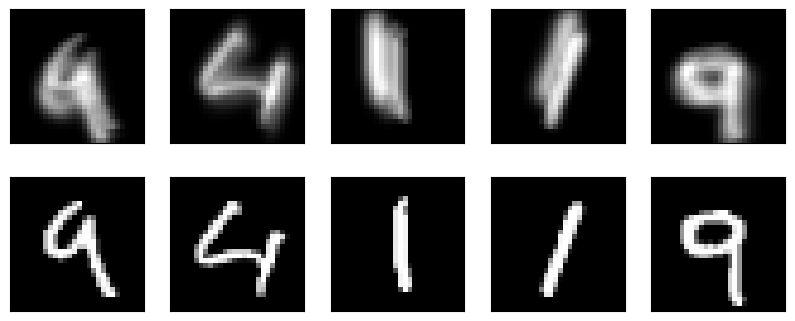

In [6]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

<br>
<br>

# **Part 2 - Re-arrange data in a proper format**

In [7]:
# Functions to prepare data
def zip_tensors(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have equal shapes.")
    return [(tensor1[i], tensor2[i]) for i in range(tensor1.shape[0])]

def data_constructor(generator):
  x, y = next(generator)
  data = zip_tensors(x, y)
  return data

In [8]:
# Since I do not have a given validation set, I reserve part of the training set (5000 elements) as validation. The final examination of the model will be done on the test set.
x_val = x_train[55000:]
x_train = x_train[:55000]

In [9]:
# Obtain a list of tuples, in which in each tuple is made by a couple of tensors. The first tensor is the blurred image, the second one is the GT image.

train_generator = generator(x_train, len(x_train)) # generation of training set (GT + blurred image)
validation_generator = generator(x_val,len(x_val)) # generation of the validation set (GT + blurred image)
test_generator = generator(x_test,len(x_test)) # generation of the test set (GT + blurred image)

train_data = data_constructor(train_generator)
validation_data = data_constructor(validation_generator)
test_data = data_constructor(test_generator)

In [10]:
# Size check, again
print(f'Training set shape: {len(train_data)}\nValidation set shape: {len(validation_data)}\nTest set shape: {len(test_data)}')

Training set shape: 55000
Validation set shape: 5000
Test set shape: 10000


In [11]:
# Those lines have the purpose of converting the data in the right format for the model. Also using NumPy allows a much more efficient efficiency, reducing times of computation
for i in range(len(train_data)):
    train_data[i] = (train_data[i][0].numpy(), train_data[i][1])

for i in range(len(validation_data)):
    validation_data[i] = (validation_data[i][0].numpy(), validation_data[i][1])

for i in range(len(test_data)):
    test_data[i] = (test_data[i][0].numpy(), test_data[i][1])

train_data_np = np.array(train_data)
validation_data_np = np.array(validation_data)
test_data_np = np.array(test_data)

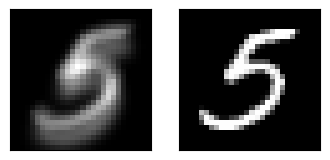

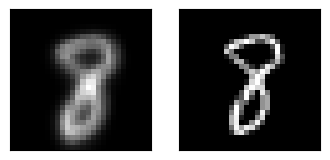

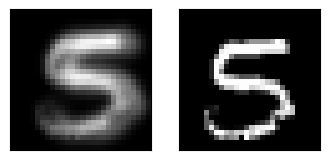

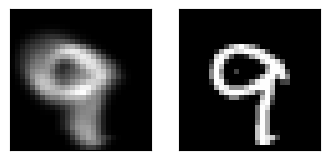

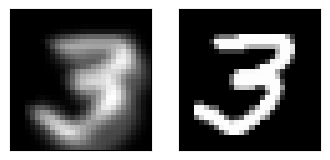

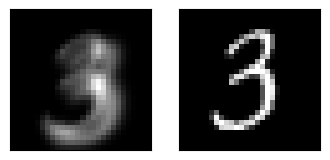

In [12]:
# Check if the process worked. As we can see, the first element of each list is the blurred image, while the second one is the GT image
plot_pair(train_data[0][0], train_data[0][1])
plot_pair(train_data[45][0], train_data[45][1])
print('\n\n')
plot_pair(validation_data[0][0], validation_data[0][1])
plot_pair(validation_data[45][0], validation_data[45][1])
print('\n\n')
plot_pair(test_data[0][0], test_data[0][1])
plot_pair(test_data[45][0], test_data[45][1])


In [13]:
# Divide the ground truth images from the blurred images
x_train = train_data_np[:, 0]
y_train = train_data_np[:, 1]

x_val = validation_data_np[:, 0]
y_val = validation_data_np[:, 1]

x_test = test_data_np[:, 0]
y_test = test_data_np[:, 1]

In [14]:
# And convert them again into NumPy arrays
x_train = np.array(list(x_train))
y_train = np.array(list(y_train))

x_val = np.array(list(x_val))
y_val = np.array(list(y_val))

x_test = np.array(list(x_test))
y_test = np.array(list(y_test))

<br>
<br>

# **Part 3 - Model**
I've chosen a straightforward **AutoEncoder (AE)** architecture. The input data undergoes encoding to generate a compressed representation, which is then decoded back to the original data. Additionally, I've incorporated a custom Mean Squared Error (MSE) loss. The rationale behind this choice is to assign less weight to black pixels (value 0). This approach allows the model to concentrate more on effectively denoising non-black pixels, which, in our dataset, represent the numbers of interest.

In [15]:
class SimpleAE(tf.keras.Model):
    def __init__(self):
        super(SimpleAE, self).__init__()

        self.encoder = models.Sequential([
            layers.Reshape((28, 28, 1), input_shape=(28, 28)),
            layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(256, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
        ])

        self.decoder = models.Sequential([
            layers.Conv2DTranspose(256, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(128, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(64, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, kernel_size=5, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(1, kernel_size=5, activation='relu', padding='same'),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def weighted_mse(y_true, y_pred):
    weights = 20 - K.cast(K.equal(y_true, 0.), K.floatx())
    mse = K.mean(weights * K.square(y_true - y_pred), axis=(1, 2))
    return mse

In [16]:
model_AE = SimpleAE()
model_AE.build((None, 28, 28, 1))
model_AE.summary()

# Compile using my custom MSE loss
model_AE.compile(optimizer='adam', loss=weighted_mse)

Model: "simple_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 256)       1078400   
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            2716801   
                                                                 
Total params: 3795201 (14.48 MB)
Trainable params: 3793281 (14.47 MB)
Non-trainable params: 1920 (7.50 KB)
_________________________________________________________________


Implement early stopping to halt training after three epochs without improvement in validation loss, with the counting starting after the completion of the 15th epoch. The use of "restore_best_weights" ensures the retention of the best configuration discovered throughout the training process.

In [17]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=3,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=15,
)

history_AE = model_AE.fit(x_train, y_train, epochs=35, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/35
3438/3438 [==============================] - 132s 36ms/step - loss: 0.4645 - val_loss: 0.1729
Epoch 2/35
3438/3438 [==============================] - 125s 36ms/step - loss: 0.1273 - val_loss: 0.1216
Epoch 3/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0976 - val_loss: 0.0931
Epoch 4/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0808 - val_loss: 0.0784
Epoch 5/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0664 - val_loss: 0.0714
Epoch 6/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0567 - val_loss: 0.0678
Epoch 7/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0496 - val_loss: 0.6572
Epoch 8/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0430 - val_loss: 0.0599
Epoch 9/35
3438/3438 [==============================] - 124s 36ms/step - loss: 0.0384 - val_loss: 0.0557
Epoch 10/35
3438/3438 [==============================] 

### Loss trend visualization

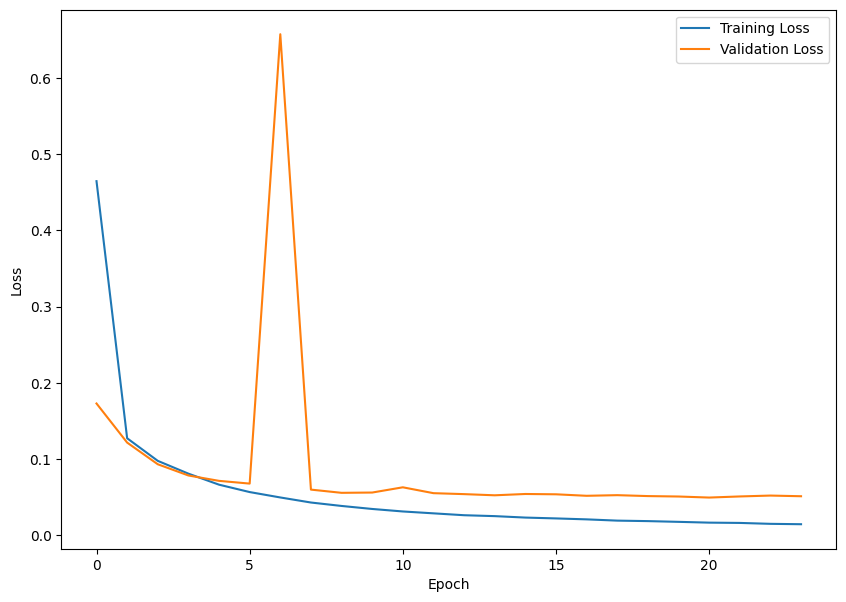

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(history_AE.history['loss'], label='Training Loss')
plt.plot(history_AE.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The decision to use 35 epochs might appear excessive at first glance. However, through empirical observation, it has been noted that in some runs, the optimal performance is achieved around the 30th epoch. The introduction of the patience parameter is intended to prevent prolonged training sessions in instances where the validation loss begins to worsen before reaching the specified number of epochs. So the idea behind this approach is to find a balance between achieving sufficient training and avoiding unnecessary computational overhead.

<br>
<br>

In some cases I observed an isolated spike in the validation loss. This is due to the fact that the validation set is really small, so it is very sensitive to some variation of the weights. However those spikes do not compromise the process of training.

<br>
<br>

# **Part 4 - Evaluation**

Use Mean Squared Error (mse) to evaluate the error between the deblurred image and the ground truth.
Measure mse on 10000 blurred versions of the validation set.

Repeat the prevevious computation 10 times, and gives as a result the **mean
mse over the ten rounds, along with the standard deviation**.

In [19]:
# Function to compute the MSE of a batch of deblurred-GT images
def compute_mse(model, images, ground_truth):
    images = np.expand_dims(images, axis=-1)
    ground_truth = np.expand_dims(ground_truth, axis=-1)

    # Predict using the model
    deblurred_images = model.predict(images)
    deblurred_images = np.expand_dims(deblurred_images, axis=-1)

    # Compute MSE
    mse = tf.keras.losses.mean_squared_error(ground_truth, deblurred_images)
    squeezed_images = np.squeeze(deblurred_images, axis=-1)
    return tf.reduce_mean(mse).numpy(), squeezed_images

313/313 [==============================] - 6s 14ms/step
Value:0.0026163305155932903


In [20]:
# This function returns a list with ten different test set, to provide the evaluation on 10 different test sets, as requested
def get_evaluation(test_generator):
  test_versions = []
  for i in range(10):
    list_A = []
    test_data = data_constructor(test_generator)
    for j in range(len(test_data)):
        test_data[j] = (test_data[j][0].numpy(), test_data[j][1])
    test_data_np = np.array(test_data)

    x_test = test_data_np[:, 0]
    y_test = test_data_np[:, 1]

    x_test = np.array(list(x_test))
    y_test = np.array(list(y_test))
    list_A.append(x_test)
    list_A.append(y_test)

    test_versions.append(list_A)
  return test_versions

test_versions = get_evaluation(test_generator)

In [21]:
# I computed the MSE and the 'deblurrd images' (obtained with my AE) for each batch and saved them in two lists.
mse_values = []
deblurred_images = []
for test_version in test_versions:
  mse_value, deblurred_image = compute_mse(model_AE, test_version[0], test_version[1])
  mse_values.append(mse_value)
  deblurred_images.append(deblurred_image)

313/313 [==============================] - 5s 15ms/step


In [22]:
# Compute the mean and standard deviation of the list of mse_values
def calculate_avg_std(numbers):
    numbers_array = np.array(numbers)
    avg = np.mean(numbers_array)
    std = np.std(numbers_array)
    return avg, std

avg, std = calculate_avg_std(mse_values)
print(f'Average mse is: {avg}')
print(f'Standard deviation of the obtained results is {std}')

Average mse is: 0.0025541302748024464
Standard deviation of the obtained results is 3.991331686847843e-05


The average MSE loss across multiple runs spans ranges from 0.0023 to 0.0026. This variability is attributed to the generation of a new training set for each run. The use of 10 distinct validation sets ensures robustness in assessing the MSE loss value, providing a more reliable evaluation of the model's performance.
The standard deviation is always really small (around 5e-5).

<br>
<br>

# **Part 5 - Analysis of the results**

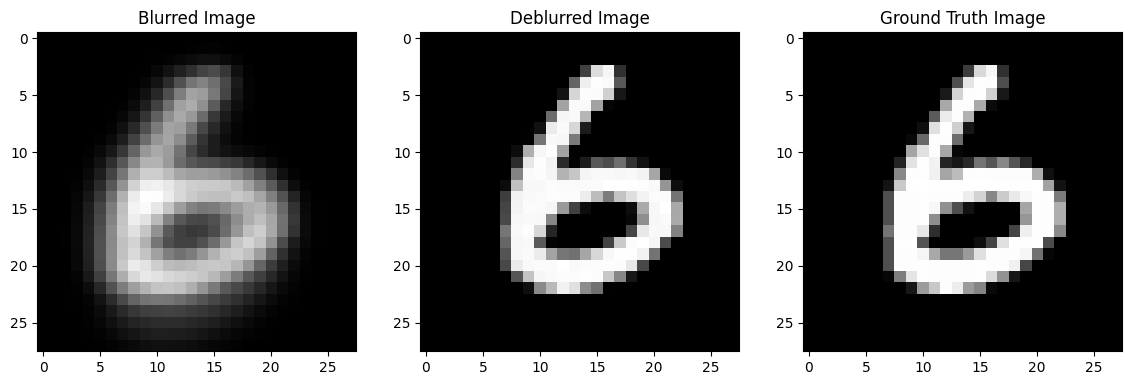

In [23]:
# Visualize some images to see the level of deblurring
fig, axes = plt.subplots(1, 3, figsize=(14, 9))
axes[0].imshow(test_versions[0][0][0], cmap='gray')
axes[0].set_title('Blurred Image')
axes[1].imshow(deblurred_images[0][0], cmap='gray')
axes[1].set_title('Deblurred Image')
axes[2].imshow(test_versions[0][1][0], cmap='gray')
axes[2].set_title('Ground Truth Image')


plt.show()

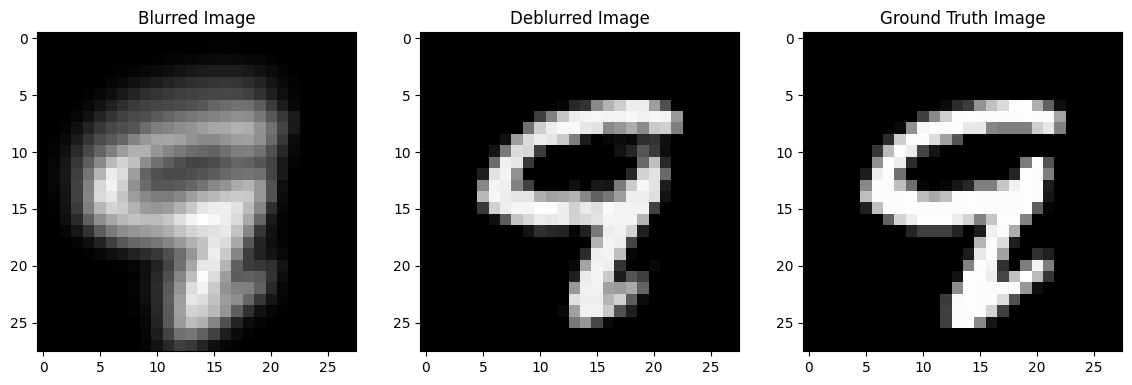

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14, 9))
axes[0].imshow(test_versions[0][0][16], cmap='gray')
axes[0].set_title('Blurred Image')
axes[1].imshow(deblurred_images[0][16], cmap='gray')
axes[1].set_title('Deblurred Image')
axes[2].imshow(test_versions[0][1][16], cmap='gray')
axes[2].set_title('Ground Truth Image')


plt.show()

The deblurred images closely resemble the ground truth images, showcasing the effectiveness of the deblurring process.

<br>
<br>

# **PART 6 - Explaining my choices**
I have chosen this particular architecture (Encoder-Decoder design + Convolutional layers and Batch Normalization layers) for various reasons:
 - Many papers describe the **AE architecture** as inherently designed for learning compact and informative representations of input data. In particular, the encoder captures essential features during encoding, and the decoder reconstructs the original image, for those reasons I found it extremely well-suited for this deblurring task that is indeed an image restoration task.
 - The use of **convolutional layers** in both the encoder and decoder enables the model to effectively capture hierarchical features in the input image. These layers give the model the ability to learn spatial hierarchies, which is crucial for this kind of task. In my experimentation, more complex models with an increased number of convolutional layers exhibited impractical levels of complexity, leading to highly unstable training. This phenomenon can be attributed to two primary factors: 1) The simplicity of MNIST images, where an overly complex model is prone to overfitting on the training set, and 2) the relatively small size of the training set, posing challenges for the model to generalize effectively. My exploration also extended to simpler models with fewer convolutional layers, but these alternatives failed to attain the level of Mean Squared Error (MSE) achieved by the specific architecture chosen.
 - **Batch normalization layers** following each convolutional layer played a pivotal role in enhancing the stability and expediting the training process. In the initial experiments conducted without these layers, training proceeded at a noticeably sluggish pace. Moreover, the inclusion of batch normalization resulted in a substantial decrease in Mean Squared Error (MSE), underscoring its effectiveness in improving both the efficiency and performance of the training process.

<br>

I also chose specific values for te hyperparameters of the model:
 - **batch_size=16:** This particular choice strikes a balance between the benefits of stochasticity and computational efficiency. While smaller batch sizes were explored with simpler models, empirical evidence revealed that, as the model complexity increased, opting for a larger batch size yielded superior results. This choice aims to strike an optimal balance for efficient and effective model training.
 - **n_Epochs=35:** The choice of 35 epochs may seem extensive, but it is based on empirical evidence from experimental analyses. In some runs, optimal performance was observed around the 30th epoch. The training was set for 35 epochs to allow the model to learn patterns thoroughly, and early stopping was implemented to prevent overfitting.
 - **Adam Optimizer:** The selection of the Adam optimizer stems from its adaptive learning rate, which proved advantageous in navigating the intricacies of training. While I did not extensively experiment with other optimizers, consistent monitoring of loss values did not reveal any anomalous behaviors that would suggest issues related to learning rate or initialization points.

Lastly, I'd like to discuss the rationale behind introducing a **custom MSE loss**. The intention behind this customization was to assign less weight to black pixels while amplifying the significance of brighter pixels. While experiments comparing the use of weighted MSE loss to its absence did not yield drastic changes, I chose to retain it due to the discernible albeit modest improvement observed. This tailored loss function aligns with the objective of fine-tuning the model's focus on specific pixel values, contributing to its overall performance.